In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pandas_ta
!pip install finta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KPI of Neuroprobabilistic Model composed by CNN+Bidirectional_LSTM

View run glowing-deluge-13 at: https://wandb.ai/stefanobutera98/KATY-AI-CNNLSTM-NEUROPROB/runs/h1n86dp3/workspace


# NeuralNetwork configuration

In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statistics as stat

config = {
    "alphaRMS": 0.8878535830123158,
    "batch_size": 128,
    "window_size": 176,
    "device": "cuda",
    "dimTrValDataSet": 0.8135103108199945,
    "dropout": 0.5255918882358939,
    "eps": 0.00000001809781643808,
    "input_size": 61,
    "l1_factor": 0.00001788764196672363,
    "l1_lambda": 0.00985428675707348,
    "learning_rateAdam": 0.000654610999498754,
    "learning_rateRMS": 0.04441832592851753,
    "momentumRMS": 0.726408866481537,
    "nStepsAhead": 24,
    "min_delta": 0.007955514357042039,
    "num_epochs": 850,
    "num_lstm_layers": 3,
    "optimizer": "Adam",
    "patience": 150,
    "scheduler": "ReduceLROnPlateau",
    "scheduler_factorCosineAnnealingWarmRestarts": 1.1189226291910723,
    "scheduler_ReduceLROnPlateau": 0.7502387107470798,
    "scheduler_min_lrCosineAnnealingWarmRestarts": 0.0000986804709547241,
    "scheduler_min_lrReduceLROnPlateau": 0.00025800234809786196,
    "scheduler_patienceCosineAnnealingWarmRestarts": 5.485778505433907,
    "scheduler_patienceReduceLROnPlateau": 8.645318720669717,
    "test_split_size": 0.14632058556123811,
    "trW": 20,
    "vlWl": 17,
    "weight_decayAdam": 0.0008131241983869834,
    "weight_decayRMS": 0.004928825586952906,
}


class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout,
               sequence_length,nStepsAhead):
    super().__init__()
    self.jitter = 1e-6

    # model definition
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False,bidirectional=True),
    )
    self.endLinearLayer = nn.Linear(2 * sequence_length,2 * nStepsAhead)

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    means ,variances = x.chunk(2, dim = -1)
    variances = self.jitter + variances
    variances = torch.clamp(variances, min=1e-3)  # Enforce a minimum positive variance
    distributions = torch.distributions.Normal(means, variances)
    return distributions

# DataSets make

# @title Testo del titolo predefinito
import pandas as pd
from finta import TA
import pandas_ta as pta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def makeDataSet():
  dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/BTCUSDT-spot-1h.csv",parse_dates=True)

  SpxData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/^SPX.csv", parse_dates=True)
  SpxData.rename(columns={'Date': 'date'}, inplace=True)
  SpxData.set_index('date', inplace=True)

  DxyData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/DX-Y.NYB.csv", parse_dates=True)
  DxyData.rename(columns={'Date': 'date'}, inplace=True)
  DxyData.set_index('date', inplace=True)

  DIXGEXData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/data/DIX.csv", parse_dates=True)
  DIXGEXData.rename(columns={'Date': 'date'}, inplace=True)
  DIXGEXData.set_index('date', inplace=True)
  dataSet = dataSet.iloc[1:]

  # Feature extraction using both `finta` and `pandas_ta`

  # Exponential Moving Average (EMA) features
  dataSet["EMA_21"] = TA.EMA(dataSet, 21)
  dataSet["EMA_50"] = TA.EMA(dataSet, 50)
  dataSet["EMA_200"] = TA.EMA(dataSet, 200)
  dataSet["HLC3"] = (dataSet["close"]  + dataSet["high"] + dataSet["low"] ) / 3

  # Average True Range (ATR) features
  dataSet["ATR"] = TA.ATR(dataSet, 24)  # Daily ATR
  dataSet["ATR_168"] = TA.ATR(dataSet, 168)  # Weekly ATR

  # Relative Strength Index (RSI)
  dataSet["RSI"] = TA.RSI(dataSet, 14)

  # Moving Average Convergence Divergence (MACD)
  macd_data = TA.MACD(dataSet)
  dataSet["MACD_line"] = macd_data["MACD"]
  dataSet["MACD_signal"] = macd_data["SIGNAL"]

  # Hull Moving Average (HMA) features

  dataSet["HMA_24"] = pta.hma(dataSet["close"], 24)

  # Bollinger Bands (BB) features
  bbands_10_data = pta.bbands(dataSet["close"], length=10, std=1.5)
  bbands_20_data = pta.bbands(dataSet["close"], length=20, std=2)
  bbands_50_data = pta.bbands(dataSet["close"], length=50, std=2.5)

  # Join BB data to the main dataset
  dataSet = dataSet.join(bbands_10_data)
  dataSet = dataSet.join(bbands_20_data)
  dataSet = dataSet.join(bbands_50_data)

  # More indicators
  dataSet["ebws"] = pta.ebsw(dataSet["close"])
  fisher_data = pta.fisher(dataSet["high"], dataSet["low"], 16)
  dataSet["FISHER"] = fisher_data.iloc[:, 0]
  dataSet["FISHERT"] = fisher_data.iloc[:, 1]

  # Detrended Price Oscillator (DPO)
  dataSet["DPO14"] = pta.dpo(close=dataSet['close'], length=14, centered=False)
  # Convert the 'date' column to a datetime format
  dataSet['date'] = pd.to_datetime(dataSet['date'])

# Set the 'date' column as the index
  dataSet = dataSet.set_index('date')


  dataSetD = dataSet.resample('D').agg({
      'open': 'first',  # Primo valore del giorno
      'high': 'max',  # Massimo valore delle 24 ore
      'low': 'min',  # Minimo valore delle 24 ore
      'close': 'last'  # Ultimo valore del giorno
  })

  previous_day = dataSetD.shift(1)
  pp = (dataSetD['high'] + dataSetD['low'] + dataSetD['close']) / 3

  r4 = pp + ((previous_day["high"] - previous_day["low"]) * 1.382)
  r3 = pp + ((previous_day["high"] - previous_day["low"]) * 1)
  r2 = pp + ((previous_day["high"] - previous_day["low"]) * 0.618)
  r1 = pp + ((previous_day["high"] - previous_day["low"]) * 0.382)

  s1 = pp - ((previous_day["high"] - previous_day["low"]) * 0.382)
  s2 = pp - ((previous_day["high"] - previous_day["low"]) * 0.618)
  s3 = pp - ((previous_day["high"] - previous_day["low"]) * 1)
  s4 = pp - ((previous_day["high"] - previous_day["low"]) * 1.382)

  # Combine the pivot levels into a single DataFrame
  pivot_data = pd.DataFrame(
      {
          'pivot': pp,
          's1': s1,
          's2': s2,
          's3': s3,
          's4': s4,
          'r1': r1,
          'r2': r2,
          'r3': r3,
          'r4': r4
      },
      index=dataSetD.index)
  # Merge the pivot data for each day into each row of hourly data that falls under that day
  dataSet = pd.merge_asof(dataSet.sort_index(),
                          pivot_data.sort_index(),
                          left_index=True,
                          right_index=True,
                          direction='backward')

  # 35, 18, 10
  # Future Line of Demarcation (FLD)
  for period in [97, 193, 385]:  # Organize the periods to calculate FLD
    src = (dataSet["close"]  + dataSet["high"] + dataSet["low"] ) / 3
    dataSet[f'FLD{period}'] = src.shift(period)
    dataSet[f'FLD{period}'].fillna(0, inplace=True)



  # Volume Weighted Average Price (VWAP)
  dataSet["D-VWAP"] = pta.vwap(high=dataSet["high"],
                              low=dataSet["low"],
                              close=dataSet["close"],
                              volume=dataSet["volume"])
  dataSet["W-VWAP"] = pta.vwap(high=dataSet["high"],
                              low=dataSet["low"],
                              close=dataSet["close"],
                              volume=dataSet["volume"],
                              anchor="W")

  # Volume Weighted Moving Average (VWMA)
  dataSet["VWMA"] = pta.vwma(close=dataSet["close"],
                            volume=dataSet["volume"],
                            length=20)

  # Easy of market move
  dataSet["EOM"] = pta.eom(high=dataSet["high"],
                          low=dataSet["low"],
                          close=dataSet["close"],
                          volume=dataSet["volume"])

  # Money flow index:
  dataSet["MFI"] = pta.mfi(high=dataSet["high"],
                          low=dataSet["low"],
                          close=dataSet["close"],
                          volume=dataSet["volume"],
                          length=14)

  SpxData.drop(SpxData.index[:2])
  DxyData.drop(DxyData.index[:3])
  SpxData.fillna(method='ffill', inplace=True)
  DxyData.fillna(method='ffill', inplace=True)

  print("_____ test IMR 1________ ")
  print(SpxData.head())
  print(DxyData.head(-1))
  print("______________________")
  # inter-market relation (IMR)
  SpxData['SPX500-DailyReturn%'] = SpxData['Close'].pct_change() * 100
  SpxData['SPXEMA20'] = TA.EMA(SpxData, 20)

  DxyData['DXY-DailyReturn%'] = DxyData['Close'].pct_change() * 100
  DxyData['DXYEMA200'] = TA.EMA(DxyData, 200)

  dataSetIMR = dataSet  # in this way we can test if IMR is useful or not

  #SpxData.drop(SpxData.index[:7168])
  #DxyData.drop(DxyData.index[:7168])

  print("_____ test IMR 2________ ")
  #print(SpxData.head())
  #print(DxyData.head(-1))
  print("______________________")

  SpxData.index = pd.to_datetime(SpxData.index)
  DxyData.index = pd.to_datetime(DxyData.index)
  DIXGEXData.index = pd.to_datetime(DIXGEXData.index)
  SpxData.index = SpxData.index.tz_localize(None)
  DxyData.index = DxyData.index.tz_localize(None)
  DIXGEXData.index = DIXGEXData.index.tz_localize(None)
  dataSetIMR.index = dataSetIMR.index.tz_localize(
      None) if dataSetIMR.index.tz is not None else dataSetIMR.index

  print("test DIX ______________")
  #print(DIXGEXData.head())
  #print(DIXGEXData.head(-1))
  print("______________________")

  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            SpxData[['SPX500-DailyReturn%', 'SPXEMA20']],
                            left_index=True,
                            right_index=True,
                            direction='backward')
  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            DxyData[['DXY-DailyReturn%', 'DXYEMA200']],
                            left_index=True,
                            right_index=True,
                            direction='backward')
  dataSetIMR = pd.merge_asof(dataSetIMR.sort_index(),
                            DIXGEXData[['dix', 'gex']],
                            left_index=True,
                            right_index=True,
                            direction='backward')

  print("test dataSetIMR ______________")
  print(dataSetIMR.head())
  print(dataSetIMR.head(-1))
  print("______________________")
  # Find the index of the first non-NaN row across all columns
  first_valid_index = dataSetIMR.dropna().index[0]

  first_valid_location = dataSetIMR.index.get_loc(first_valid_index)

  dataSetIMRCleaned = dataSetIMR.iloc[first_valid_location:]

  print(dataSetIMR[['SPXEMA20', 'DXYEMA200']].dtypes)
  print(dataSetIMR[['SPXEMA20', 'DXYEMA200']])

  # dataSetIMR.fillna(method='ffill', inplace=True)  # ho le chiusure del weekand così risolvo il problema

  dataSetIMRCleaned = dataSetIMRCleaned.select_dtypes(
      include=['float64', 'int64'])
  dataSetIMRCleaned['SPX500-DailyReturn%'] = pd.to_numeric(
      dataSetIMRCleaned['SPX500-DailyReturn%'], errors='coerce')
  dataSetIMRCleaned['DXY-DailyReturn%'] = pd.to_numeric(
      dataSetIMRCleaned['DXY-DailyReturn%'], errors='coerce')

  dataSetIMRCleaned['EOM'].fillna(0, inplace=True)

  dataSet.replace([np.inf, -np.inf], 0, inplace=True)

  pd.set_option('display.max_columns', None)

  print("test dataSetIMR ______________")
  print(dataSetIMRCleaned)
  #dataSetIMRCleaned.info()
  print("______________________")
  #dataSetIMRCleaned.to_csv('FeatureEngineering&DATA/dataSetIMRCleanedHLC3.csv',index=False)
  #dataSetIMRCleaned.head()
  return dataSetIMRCleaned

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/NeuroProbabilistico/NeuroProb/NeuroProbPTH/NeuroProbBidirect2.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(config["input_size"],config["num_lstm_layers"],config["dropout"],config["window_size"],config["nStepsAhead"])
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
# Dataset download
dataSetClean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRCleanedLC2.csv")
lc2 = dataSetClean['lc2']
dataSetClean.drop(labels=['lc2'], axis=1, inplace=True)
oc2 = (dataSetClean['open']+ dataSetClean['close'])/2
dataSetClean.insert(0, 'oc2', oc2)
dataSetClean.replace([np.inf, -np.inf], np.nan, inplace=True)
dataSetClean.fillna(method='ffill', inplace=True)
dataSetClean.fillna(method='bfill', inplace=True)
dataSetClean.info()


# Dataloading (sliding windows)
config["input_size"] = 61  # with 1 have number of features

# Normalize
scaler = MinMaxScaler()
scaler.fit(dataSetClean)
dataSet = scaler.transform(dataSetClean)
dataSet1 = pd.DataFrame(dataSet)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52433 entries, 0 to 52432
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oc2                  52433 non-null  float64
 1   open                 52433 non-null  float64
 2   high                 52433 non-null  float64
 3   low                  52433 non-null  float64
 4   close                52433 non-null  float64
 5   volume               52433 non-null  float64
 6   volume_quote         52433 non-null  float64
 7   trades               52433 non-null  int64  
 8   taker_buy            52433 non-null  float64
 9   taker_buy_quote      52433 non-null  float64
 10  EMA_21               52433 non-null  float64
 11  EMA_50               52433 non-null  float64
 12  EMA_200              52433 non-null  float64
 13  ATR                  52433 non-null  float64
 14  ATR_168              52433 non-null  float64
 15  RSI                  52433 non-null 

In [ ]:
dataSet2 = makeDataSet()
# Dataset download
dataSet2.drop(labels=['HLC3'], axis=1, inplace=True)
oc2 = (dataSet2['open']+ dataSet2['close'])/2
dataSet2.insert(0, 'oc2', oc2)
dataSet2.replace([np.inf, -np.inf], np.nan, inplace=True)
dataSet2.fillna(method='ffill', inplace=True)
dataSet2.fillna(method='bfill', inplace=True)
dataSet2.info()
# Dataloading (sliding windows)
config["input_size"] = 61  # with 1 have number of features
# Normalize
scaler = MinMaxScaler()
scaler.fit(dataSet2)
dataSet2 = scaler.transform(dataSet2)
dataSet2 = pd.DataFrame(dataSet2)

<ipython-input-125-244c9b93ee6e>:123: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["D-VWAP"] = pta.vwap(high=dataSet["high"],
<ipython-input-125-244c9b93ee6e>:123: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["D-VWAP"] = pta.vwap(high=dataSet["high"],
<ipython-input-125-244c9b93ee6e>:127: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["W-VWAP"] = pta.vwap(high=dataSet["high"],
<ipython-input-125-244c9b93ee6e>:127: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataSet["W-VWAP"] = pta.vwap(high=dataSet["high"],


_____ test IMR 1________ 
                   Open         High          Low        Close    Adj Close  \
date                                                                          
2017-01-03  2251.570068  2263.879883  2245.129883  2257.830078  2257.830078   
2017-01-04  2261.600098  2272.820068  2261.600098  2270.750000  2270.750000   
2017-01-05  2268.179932  2271.500000  2260.449951  2269.000000  2269.000000   
2017-01-06  2271.139893  2282.100098  2264.060059  2276.979980  2276.979980   
2017-01-09  2273.590088  2275.489990  2268.899902  2268.899902  2268.899902   

                Volume  
date                    
2017-01-03  3773010000  
2017-01-04  3768890000  
2017-01-05  3785080000  
2017-01-06  3342080000  
2017-01-09  3219730000  
                  Open        High         Low       Close   Adj Close  Volume
date                                                                          
2017-01-03  102.870003  103.820000  102.589996  103.209999  103.209999     0.0
2017-01-

# Service function

In [ ]:
def plot_results(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    palette = sns.color_palette()

    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)

    ax.plot(y_mid, y_mid, '--', color=palette[1])
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5);

    return f, ax

In [ ]:
from sklearn.metrics import median_absolute_error,mean_absolute_error,explained_variance_score


class ResultManager():
  def __init__(self,pred,target):
    self.pred = pred
    self.target = target

  def getPred(self):
    return self.predTR


  def getTarget(self):
    return self.targetTR


  def makeDfResult(self):
    pred = flatten_if_nested(self.pred)
    target = flatten_if_nested(self.target)
    means = []
    devs = []
    for y_hat in pred:
      means.extend(y_hat.loc.tolist())
      devs.extend(y_hat.scale.tolist())
    means = flatten_if_nested(means)
    devs = flatten_if_nested(devs)
    df = pd.DataFrame({
      "target":target,
      "mean": means,
      "std": devs,
    })
    return df

  def acper_complessivo(self,val,dfResult):
    threshold = val
    # Calcolo del limite inferiore e superiore
    lower_bound = dfResult["target"] - (threshold * dfResult["target"])
    upper_bound = dfResult["target"] + (threshold * dfResult["target"])
    # Controllo se y_pred è tra i limiti e calcolo la percentuale di True
    matches = (dfResult["mean"] >= lower_bound) & (dfResult["mean"] <= upper_bound)
    # Calcolo la percentuale di corrispondenze soddisfacenti la condizione
    percentuale_acper = (matches.sum() / len(dfResult)) * 100
    return percentuale_acper


  def overallKpiCompute(self,dfResult):
    print("call me")

    mse = mean_squared_error(dfResult["target"],dfResult["mean"])
    rmse = mean_squared_error(dfResult["target"],dfResult["mean"], squared=False)
    r2 = r2_score(dfResult["target"],dfResult["mean"])
    mae = mean_absolute_error(dfResult["target"],dfResult["mean"])
    aae = median_absolute_error(dfResult["target"],dfResult["mean"])
    evs = explained_variance_score(dfResult["target"],dfResult["mean"])
    acper2 = self.acper_complessivo(0.02,dfResult)
    acper5 = self.acper_complessivo(0.05,dfResult)
    ape =  np.mean(np.abs((dfResult["target"]- dfResult["mean"])) / np.array(dfResult["target"]), axis=0)

    #  compute accuracy
    real = dfResult["target"]
    predict = dfResult["mean"]
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    acc =  percentage * 100
    index = [i for i in range(0,1,1)]

    KpiDf = pd.DataFrame({
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mae": mae,
        "evs": evs,
        "acper2": acper2,
        "acper5": acper5,
        "ape": ape,
        "acc": acc,
    },index = index)
    print(KpiDf)

    KpiDf = pd.DataFrame(KpiDf)
    KpiDf.head()


    return KpiDf


In [ ]:
def compute_loss(model, x, y, kl_reg=0.1):
    y_hat = model(x)
    neg_log_likelihood = -y_hat.log_prob(y)
    return torch.mean(neg_log_likelihood),y_hat

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data


    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


def getDataSet(x,y):
    dataSet = TimeSeriesDataset(x, y)
    return dataSet


def getDataLoader(dataSet,config):
  loader = DataLoader(dataset=dataSet,
                          batch_size=config["batch_size"],
                          shuffle=False)
  return loader



In [ ]:
def compute_rmse(model, y_hat, y_test, num_samples=1000):
    y_hat_samples = y_hat.sample((num_samples,))  # Draw multiple samples

    errors = y_hat_samples - y_test  # Calculate errors for each sample
    squared_errors = errors ** 2
    mean_squared_error = torch.mean(squared_errors, dim=0)  # Average across samples
    rmse = torch.sqrt(mean_squared_error)

    return rmse

In [ ]:
def flatten_if_nested(lst):

    # Initialize an empty list to store the flattened elements
    flat_list = []

    # Iterate through each element in the input list
    for item in lst:
        # If the element is a list, extend the flat list with the flattened version of this element
        if isinstance(item, list):
            flat_list.extend(flatten_if_nested(item))
        # If the element is not a list, simply append it to the flat list
        else:
            flat_list.append(item)

    return flat_list

In [ ]:
def testLoop(model, testX_tensor,testY_tensor,config):
  all_predictionsVL = []
  all_targetsVL = []
  model.eval()
  losses_v, rmse_v = [], []
  dataSetTS = getDataSet(testX_tensor,testY_tensor)
  test_loader =getDataLoader(dataSetTS,config)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["device"]), target.to(
        config["device"])
      target = target.squeeze(1)
      # Forward pass ➡
      loss,y_hat = compute_loss(model, data, target)
      #b_val_rmse = compute_rmse(model, y_hat, target)
      losses_v.append(loss.detach().cpu().numpy())
      #rmse_v.append(b_val_rmse.detach().cpu().numpy())
      #means = y_hat.loc.tolist()
      #std_devs = y_hat.scale.tolist()

      all_predictionsVL.append(y_hat)
      all_targetsVL.extend(
            target.squeeze().tolist())
  losses_v = np.array(losses_v)
  avg_loss = np.mean(losses_v)

  return avg_loss,all_predictionsVL,all_targetsVL

In [ ]:
# function to divide the dataSet into windows (X lenght = window_size; Y lenght = nStepsAhead)

def slidingWindowsAhead(df, windowSize, nStepsAhead,dimTrValDataSet):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values
      x.append(_x)
      y.append(_y)

  # convert windows in tensor
  np.array(x)
  np.array(y)
  trVlWnum = int(len(x) * dimTrValDataSet)
  testWnum = len(x) - trVlWnum  # Remaining data for testing

  trVlX = x[:trVlWnum]
  testX = x[trVlWnum:]
  trVlY = y[:trVlWnum]
  testY = y[trVlWnum:]

  #print("_______ Dim mX & mY ______")
  #print(f"dim mX:{len(x)} dim mY:{len(y)}")
  #print("_____Dimension X & Y _____")
  #print(f"dim trValX:{len(trVlX)} --- dim trValY:{len(trVlY)} ")

  #print(f"dim testX:{len(testX)} --- dim testY:{len(testY)} ")

  # Convert from numpy arrays to torch tensors
  trVlX_tensor = torch.tensor(trVlX, dtype=torch.float32)
  trVlY_tensor = torch.tensor(trVlY, dtype=torch.float32).unsqueeze(1)
  testX_tensor = torch.tensor(testX, dtype=torch.float32)
  testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

  #print("_____Dimension X & Y tensor _____")
  #print(f"dim TR&VAL X:{trVlX_tensor.shape} --- dim TR&VAL Y:{trVlY_tensor.shape} ")
  #print(f"dim TEST X:{testX_tensor.shape} --- dim TEST Y:{testY_tensor.shape} ")

  #print(f"trVlX_tensor{trVlX_tensor[:10]}")
  #print(f"trVlX_tensor{trVlY_tensor[:10]}")


  return trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor

# KPI computation

In [ ]:
trVlX_tensor1,trVlY_tensor1,testX_tensor1,testY_tensor1 = slidingWindowsAhead(dataSet1,config["window_size"], config["nStepsAhead"],config["dimTrValDataSet"])
trVlX_tensor2,trVlY_tensor2,testX_tensor2,testY_tensor2 = slidingWindowsAhead(dataSet2,config["window_size"], config["nStepsAhead"],config["dimTrValDataSet"])
avg_lossTRVL,predTRVL,targetTRVL =  testLoop(model, trVlX_tensor1,trVlY_tensor1,config)
# make prediction on TestSet
avg_lossTS1,predTS1,targetTS1 =  testLoop(model, testX_tensor1,testY_tensor1,config)
avg_lossTS2,predTS2,targetTS2 =  testLoop(model, testX_tensor2,testY_tensor2,config)


resultManagerTRVL = ResultManager(predTRVL,targetTRVL)
resultManagerTS1 = ResultManager(predTS1,targetTS1)
resultManagerTS2 = ResultManager(predTS2,targetTS2)
dfResultTRVL = resultManagerTRVL.makeDfResult()
dfResultTS1 = resultManagerTS1.makeDfResult()
dfResultTS2 = resultManagerTS2.makeDfResult()
dfKPI_TRVL  = resultManagerTRVL.overallKpiCompute(dfResultTRVL)
dfKPI_TS1  = resultManagerTS1.overallKpiCompute(dfResultTS1)
dfKPI_TS2  = resultManagerTS2.overallKpiCompute(dfResultTS2)


print(f"Dim predTRVL:{len(predTRVL)} \n Dim targetTRVL: {len(targetTRVL)} \n Dim predTS: {len(predTS1)} \n Dim targetTS: {len(targetTS1)} \n Dim dfResultTRVL: {len(dfResultTRVL)} \n Dim dfResultTS2: {len(dfResultTS2)}")

call me
        mse      rmse        r2       mae     evs    acper2    acper5  ape  \
0  0.000457  0.021384  0.993383  0.014261  0.9939  15.47619  43.97939  inf   

   acc  
0 -inf  
call me
        mse      rmse        r2       mae      evs     acper2     acper5  \
0  0.000163  0.012783  0.985765  0.009041  0.98656  53.797209  91.522989   

        ape       acc  
0  0.023231  96.88966  
call me
        mse      rmse        r2       mae       evs     acper2    acper5  \
0  0.000298  0.017261  0.987831  0.010706  0.988545  57.155582  90.37015   

        ape        acc  
0  0.022818  96.878134  
Dim predTRVL:14 
 Dim targetTRVL: 1771 
 Dim predTS: 4 
 Dim targetTS: 406 
 Dim dfResultTRVL: 42504 
 Dim dfResultTS2: 10104


In [ ]:
print("KPI on TRVL \n")
dfKPI_TRVL.head(1)

KPI on TRVL 



,mse,rmse,r2,mae,evs,acper2,acper5,ape,acc
0,0.000457,0.021384,0.993383,0.014261,0.9939,15.47619,43.97939,inf,-inf


In [ ]:
print("KPI on TS1 \n")
dfKPI_TS1.head(1)

KPI on TS1 



,mse,rmse,r2,mae,evs,acper2,acper5,ape,acc
0,0.000163,0.012783,0.985765,0.009041,0.98656,53.797209,91.522989,0.023231,96.88966


In [ ]:
print("KPI on TS2 \n")
dfKPI_TS2.head(1)

KPI on TS2 



,mse,rmse,r2,mae,evs,acper2,acper5,ape,acc
0,0.000298,0.017261,0.987831,0.010706,0.988545,57.155582,90.37015,0.022818,96.878134


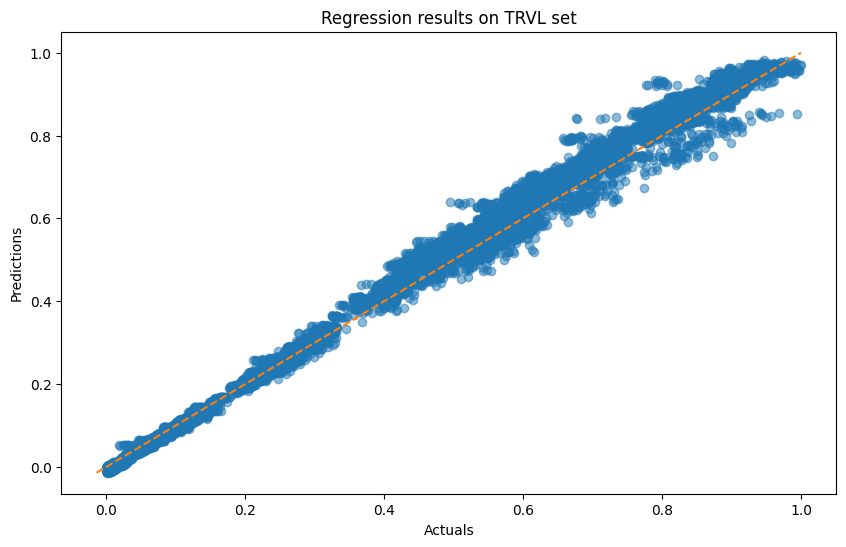

In [ ]:
f, ax = plot_results(
    dfResultTRVL["target"].to_numpy().flatten(),
    dfResultTRVL["mean"].to_numpy().flatten(),
);



ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on TRVL set');

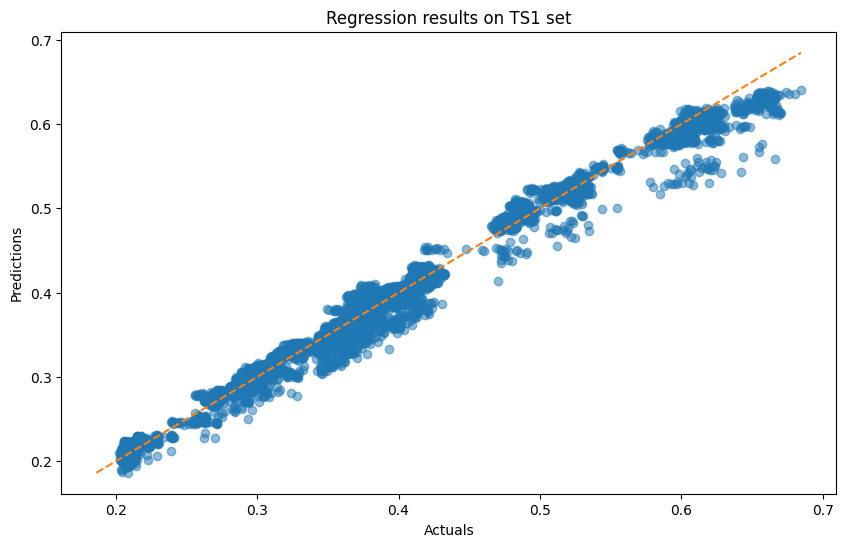

In [ ]:
f, ax = plot_results(
    dfResultTS1["target"].to_numpy().flatten(),
    dfResultTS1["mean"].to_numpy().flatten(),
);



ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on TS1 set');

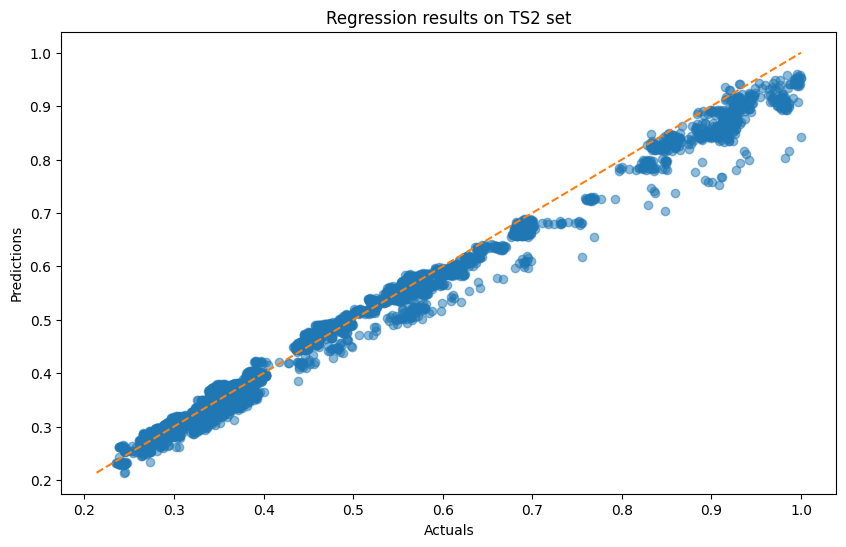

In [ ]:
f, ax = plot_results(
    dfResultTS2["target"].to_numpy().flatten(),
    dfResultTS2["mean"].to_numpy().flatten(),
);



ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on TS2 set');

# ROC curve

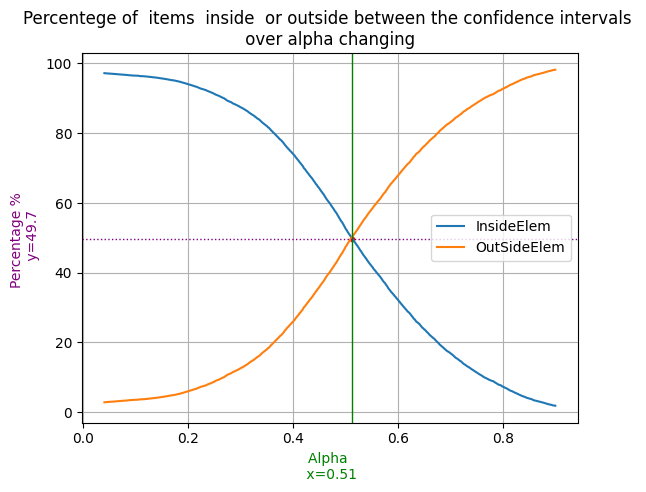

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

means = dfResultTS2["mean"]
targets = dfResultTS2["target"]
new_index = pd.RangeIndex(start=0, stop=len(dfResultTS2))
targets = np.asarray(targets).flatten()
means = np.asarray(means).flatten()

df = pd.DataFrame({
    "means": means,
    "targets": targets
}, index = new_index)
confidence_levels = np.arange(0.10, 0.96, 0.001)

telList = []
felList = []
tel_percentageList = []
fel_percentageList = []
alphaList = []

for confidence_level in confidence_levels:
    tel = 0
    fel = 0
    alpha = 1 - confidence_level

    z_score = np.abs(stats.norm.ppf(alpha / 2))

    confidence_intervals = z_score * dfResultTS2["std"]
    confidence_intervals = pd.DataFrame(confidence_intervals)

    for index, (target, mean, confidence_interval) in enumerate(zip(df["targets"], df["means"], confidence_intervals.iloc[:, 0])):
        if target >= mean - confidence_interval * z_score and target <= mean + confidence_interval * z_score:
            tel += 1
        else:
            fel += 1

    total_count = tel + fel
    telList.append(tel)
    felList.append(fel)

    tel_percentage = (tel / total_count) * 100
    fel_percentage = (fel / total_count) * 100
    alphaList.append(alpha)
    tel_percentageList.append(tel_percentage)
    fel_percentageList.append(fel_percentage)

df = pd.DataFrame({
    "alphaValues": alphaList,
    "tel_percentage": tel_percentageList,
    "fel_percentage": fel_percentageList
})



# Create the figure and axis
fig, ax = plt.subplots()


idx = np.argwhere(np.diff(np.sign(df["tel_percentage"].to_numpy() - df["fel_percentage"].to_numpy()))).flatten()
x_intersect = df["alphaValues"].iloc[idx]
y_intersect = df["tel_percentage"].iloc[idx]

x_intersect_list = x_intersect.tolist()
x = x_intersect_list[0]
y_intersect_list = y_intersect.tolist()
y = flatten_if_nested(y_intersect_list)

plt.plot(x, y, 'ro', markersize=3)  # Red circle marker



ax.plot(df["alphaValues"], df["tel_percentage"], label='InsideElem')
ax.plot(df["alphaValues"], df["fel_percentage"], label='OutSideElem')
ax.axvline(x=x, color='g', linestyle='-', linewidth=1)
ax.axhline(y=y, color='purple', linestyle='dotted', linewidth=1)
x = round(x,2)
y = round(y[0],2)
# Add labels to the axes
plt.xlabel(f'Alpha \n x={x}')
plt.xlabel(f'Alpha \n x={x}', color='g')
plt.ylabel(f'Percentage % \n y={y}', color='purple')
plt.title("Percentege of  items  inside  or outside between the confidence intervals \n over alpha changing ")
plt.legend()
plt.grid()


plt.show()





# Prediction charts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plotPredChart(means, target, ochl4, confidence_intervals):
    plt.figure(figsize=(42, 18))
    ochl4 = np.asarray(ochl4).flatten()
    confidence_intervals = np.asarray(confidence_intervals).flatten()
    target = np.asarray(target).flatten()
    means = np.asarray(means).flatten()


    df = pd.DataFrame({
    "means": means,
    "target": target,
    "OCHL4": ochl4,
    "confidence_intervals": confidence_intervals,
    })

    # Main prediction line
    plt.plot(df["means"], label='Predicted Means')

    # Target values
    plt.plot(df["target"], label='Targets')

    # OCHL4
    plt.plot(df["OCHL4"], label="OCHL4")

    # Confidence Intervals
    plt.fill_between(np.arange(len(df)),
                     df["means"] - df["confidence_intervals"],
                     df["means"] + df["confidence_intervals"],
                     alpha=0.5, label=f'{confidence_level * 100}% Confidence')

    # Styling
    plt.xlabel('Time Step')
    plt.ylabel('BTC Price')
    plt.title('Bidirectional CNNLSTM with Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()


means = dfResultTS2["mean"]
targets = dfResultTS2["target"]

confidence_level = 0.75
alpha = 1 - confidence_level
z_critical = np.abs(stats.norm.ppf(alpha / 2))
print(z_critical)
TSdf = dataSet2[(len(dataSet2) - len(targets)):]
OCHL4 = (TSdf[1] + TSdf[4] + TSdf[2] + TSdf[3]) / 4
OCHL4 = pd.DataFrame(OCHL4)
new_index = pd.RangeIndex(start=0, stop=len(dfResultTS2))
OCHL4 = OCHL4.set_index(new_index)
confidence_intervals = z_critical * dfResultTS2["std"]  # Ensure "std" column exists
confidence_intervals = pd.DataFrame(confidence_intervals)



OCHL4 = np.asarray(OCHL4).flatten()
confidence_intervals = np.asarray(confidence_intervals).flatten()
targets = np.asarray(targets).flatten()
means = np.asarray(means).flatten()

df = pd.DataFrame({
    "means": means,
    "targets": targets,
    "OCHL4": OCHL4,
    "confidence_intervals": confidence_intervals,
},index = new_index)

plotPredChart(means[:], targets[:], OCHL4[:], confidence_intervals[:])
plotPredChart(means[:72], targets[:72], OCHL4[:72], confidence_intervals[:72])
plotPredChart(means[72:144], targets[72:144], OCHL4[72:144], confidence_intervals[72:144])
plotPredChart(means[144:1500], targets[144:1500], OCHL4[144:1500], confidence_intervals[144:1500])
plotPredChart(df["means"].iloc[1500:3000],df["targets"].iloc[1500:3000],df["OCHL4"].iloc[1500:3000],df["confidence_intervals"].iloc[1500:3000])
plotPredChart(df["means"].iloc[3000:3100],df["targets"].iloc[3000:3100],df["OCHL4"].iloc[3000:3100],df["confidence_intervals"].iloc[3000:3100])
plotPredChart(df["means"].iloc[3100:3500],df["targets"].iloc[3100:3500],df["OCHL4"].iloc[3100:3500],df["confidence_intervals"].iloc[3100:3500])
plotPredChart(df["means"].iloc[3500:4500],df["targets"].iloc[3500:4500],df["OCHL4"].iloc[3500:4500],df["confidence_intervals"].iloc[3500:4500])
plotPredChart(df["means"].iloc[4500:5555],df["targets"].iloc[4500:5555],df["OCHL4"].iloc[4500:5555],df["confidence_intervals"].iloc[4500:5555])
plotPredChart(df["means"].iloc[5555:6555],df["targets"].iloc[5555:6555],df["OCHL4"].iloc[5555:6555],df["confidence_intervals"].iloc[5555:6555])
plotPredChart(df["means"].iloc[6555:7555],df["targets"].iloc[6555:7555],df["OCHL4"].iloc[6555:7555],df["confidence_intervals"].iloc[6555:7555])
plotPredChart(df["means"].iloc[7555:8555],df["targets"].iloc[7555:8555],df["OCHL4"].iloc[7555:8555],df["confidence_intervals"].iloc[7555:8555])
plotPredChart(df["means"].iloc[8555:-1],df["targets"].iloc[8555:-1],df["OCHL4"].iloc[8555:-1],df["confidence_intervals"].iloc[8555:-1])



Output hidden; open in https://colab.research.google.com to view.